# Regression task

## General overview
In this homework you will learn how to implement and test simple neural network models for solving supervised problems. It is divided in two tasks.

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 

* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of Zalando's article images (Fashion MNIST). 

In both cases, but especially for the classification problem, you should explore the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. For the image classification task, you can also implement more advanced convolutional architectures and explore feature visualization techniques to better understand how the deep network is encoding information at different processing layers.


## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: implement basic regression and classification tasks
*	2 pt: explore advanced optimizers and regularization methods (both tasks)
*	1 pt: optimize hyperparameters using grid/random search and cross-validation (both tasks)
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields


## Guidelines

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

## Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

The following cell of code will download the dataset and make it available in the local folder `regression_dataset`. There are two files:

* `regression_dataset/train_data.csv`
* `regression_dataset/test_data.csv`

Use them to train and test your model. Each row contains two values, respactively the input and the target (label).

In [5]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 

--2021-11-23 13:29:41--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv’

train_data.csv      100%[===================>]   3.69K  --.-KB/s    in 0s      

2021-11-23 13:29:42 (53.6 MB/s) - ‘regression_dataset/train_data.csv’ saved [3776/3776]

--2021-11-23 13:29:42--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘regression_dataset/test_data.csv’

test_data.csv 

How to load the data:

In [100]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df=pd.read_csv('regression_dataset/test_data.csv')

## How to get a specific sample:

In [7]:
sample_index = 0
input = train_df.iloc[sample_index]['input']
label = train_df.iloc[sample_index]['label']

print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

SAMPLE AT INDEX 0
INPUT: -4.787870188090535
LABEL: -1.216803599957529


All training points:

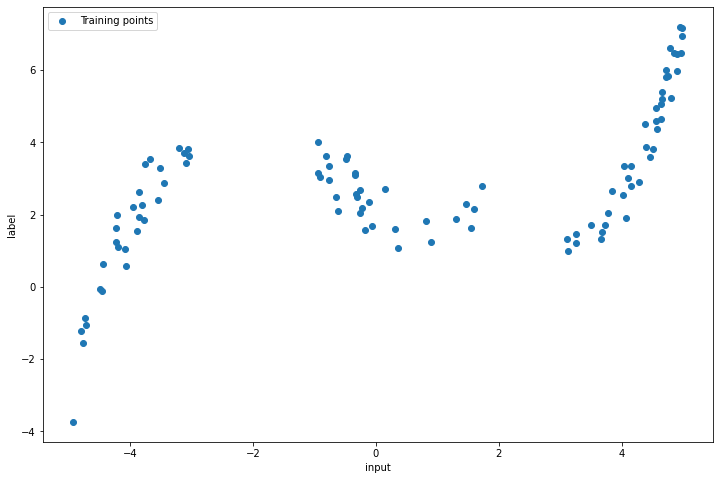

In [8]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

## Exercise

In [89]:
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.Sigmoid()
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x)) #don't forget activation: not included by default 
        x = self.act(self.fc2(x))
        x = self.out(x)
        return x

In [187]:
class CsvDataset(Dataset):

  def __init__(self, csv_file: str, transform=None):
    self.transform = transform
    self.data = csv_file

  def __len__(self):
    # The length of the dataset is simply the length of the self.data list
    return len(self.data)

  def __getitem__(self, idx):
    # sample: ('index', 'label) --> sample = (csv_file index elem, csv_file column element)
    sample = (self.data.iloc[idx][0], self.data.iloc[idx][1])
    if self.transform:
        sample = self.transform(sample)
    return sample


In [155]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

In [188]:
train_split, val_split = train_test_split(train_df,test_size=0.1, shuffle= True)
train_split = train_split.reset_index(drop=True)
val_split = val_split.reset_index(drop=True)

In [189]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset(train_split, transform=composed_transform)
val_dataset = CsvDataset(val_split, transform=composed_transform)
test_dataset= CsvDataset(test_df, transform=composed_transform)


In [190]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_dataloader  = DataLoader(val_dataset,  batch_size=len(val_dataset), shuffle=False, num_workers=0)



In [191]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


In [192]:
# Initialize the network
torch.manual_seed(0)
Ni = 1
Nh1 = 128
Nh2 = 256
No = 1
net = Net(Ni, Nh1, Nh2, No)
net.to(device)

# Define the loss function
loss_fn = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-3)

Network initialized


In [198]:
### TRAINING LOOP

#SG run some epochs over the data, to do this a just a for loop, inside we loop over the batches. 
#Here the network must be in training mode.

num_epochs = 3000
train_loss_log = []
val_loss_log = []
for epoch_num in range(num_epochs):
    #print('#################')
    #print(f'# EPOCH {epoch_num}')
    #print('#################')

    ### TRAIN
    train_loss= []
    net.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
    for sample_batched in train_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out = net(x_batch)

        # Compute loss
        loss = loss_fn(out, label_batch)

        # Backpropagation
        net.zero_grad() #set all the gradient to zero
        loss.backward() #call the backward func.

        # Update the weights
        optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    #print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)

    ### VALIDATION
    val_loss= []
    #Set network in evaluation mode, parameters are frozd, in this case we do the 
    #validation after every step of the training
    
    net.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
    with torch.no_grad(): # Disable gradient tracking
        for sample_batched in val_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = net(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)

        # Save average validation loss
        val_loss = np.mean(val_loss)
        #print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
        val_loss_log.append(val_loss)

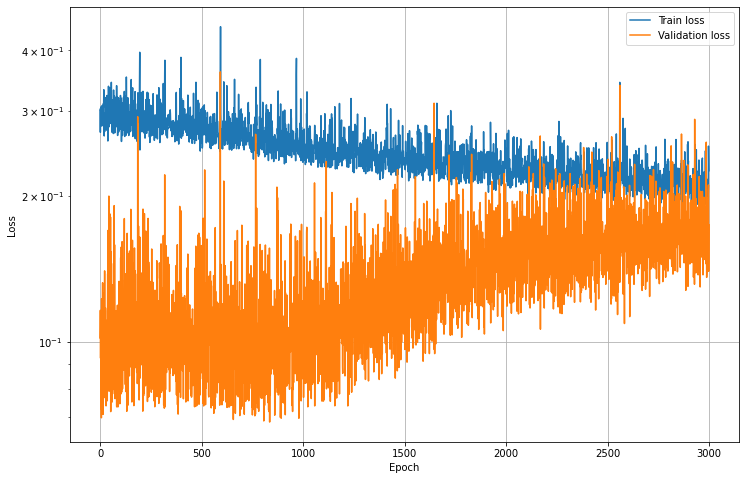

In [199]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()